In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

# Localization 1

In [5]:
vgg = tf.keras.applications.VGG16(
    input_shape=[100, 100, 3], 
    include_top=False,
    weights="imagenet"
)

In [6]:
def window_pic_generator(batch_num = 50, batch_size = 64):
    while True:
        for _ in range(batch_num):
            X = np.zeros((batch_size, 100, 100, 3))
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size):
                x_0, y_0 = np.random.randint(90), np.random.randint(90)
                x_1, y_1 = np.random.randint(x_0, 90), np.random.randint(y_0, 90)
                X[i, x_0:x_1, y_0:y_1,:] = 1
                Y[i,:] = [x_0/100, y_0/100, (x_1-x_0)/100, (y_1-y_0)/100]
        yield X, Y

In [19]:
x = Flatten()(vgg.output)
x = Dense(4, activation="sigmoid")(x)
model = Model(vgg.input, x)
model.compile(loss = "binary_crossentropy", 
optimizer = Adam(learning_rate = 1e-3))

model.fit_generator(
    window_pic_generator(), 
    steps_per_epoch = 50,
    epochs = 5
)

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
50/50 [==============================] - 293s 6s/step - loss: 0.6403
Epoch 2/5
50/50 [==============================] - 224s 4s/step - loss: 0.5681
Epoch 3/5
50/50 [==============================] - 223s 4s/step - loss: 0.5178
Epoch 4/5
50/50 [==============================] - 227s 5s/step - loss: 0.5029
Epoch 5/5
50/50 [==============================] - 229s 5s/step - loss: 0.5011


In [20]:
def make_prediction(model):

    x = np.zeros((100, 100, 3))
    x_0, y_0 = np.random.randint(0, 90), np.random.randint(0, 90)
    x_1, y_1 = np.random.randint(x_0, 100), np.random.randint(y_0, 100)
    x[x_0:x_1, y_0:y_1, :] = 3
    
    X = np.expand_dims(x, 0)
    pred = model.predict(X)[0]

    _, ax = plt.subplots(1)
    ax.imshow(x)
    rect = Rectangle(
        (pred[1]*100, pred[0]*100),
        pred[3]*100, pred[2]*100, linewidth = 1, edgecolor = "r", facecolor = "None"
    )
    ax.add_patch(rect)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


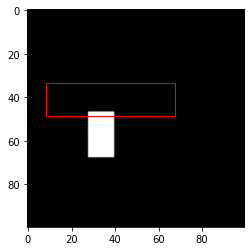

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


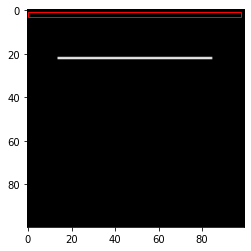

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


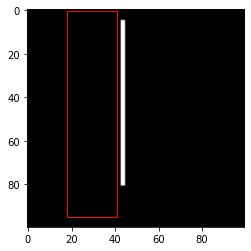

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


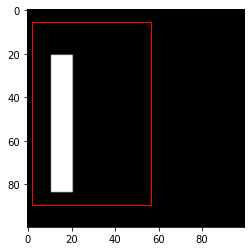

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


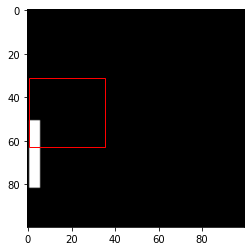

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


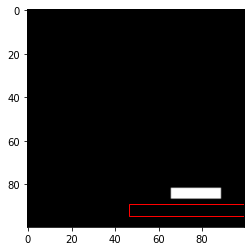

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


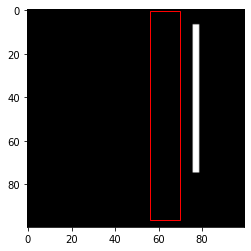

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


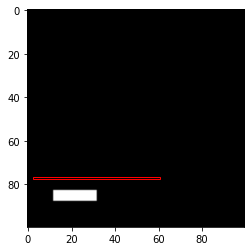

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


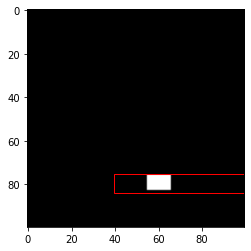

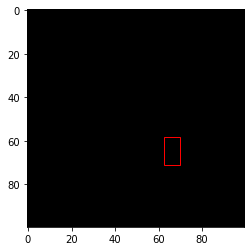

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


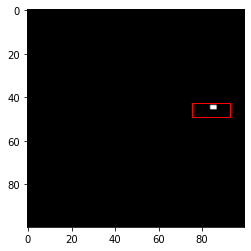

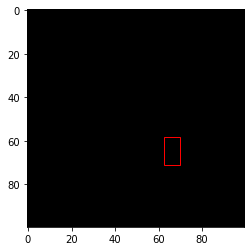

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


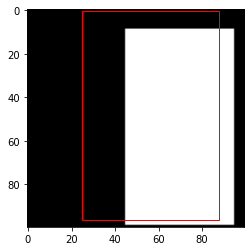

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


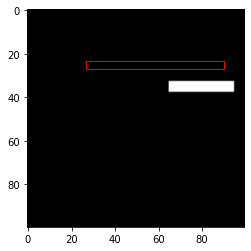

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


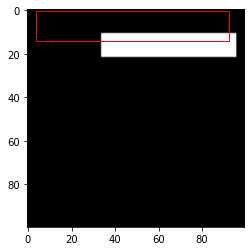

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


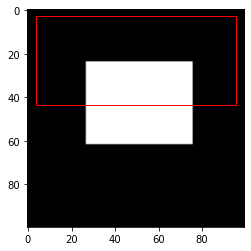

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


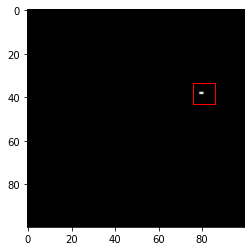

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


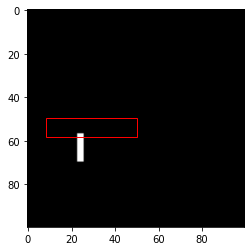

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


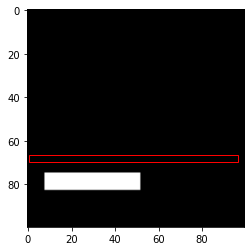

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


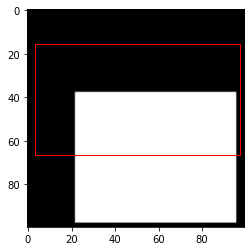

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


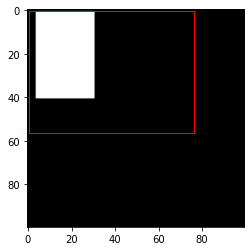

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


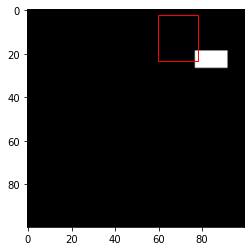

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


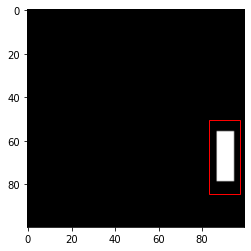

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


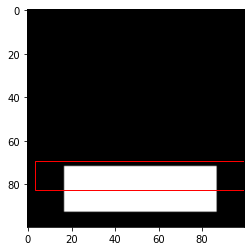

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


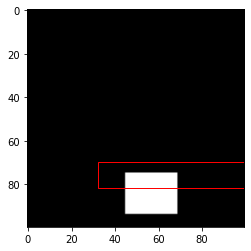

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


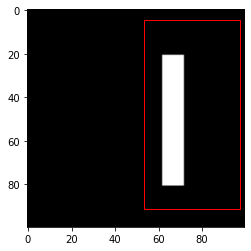

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


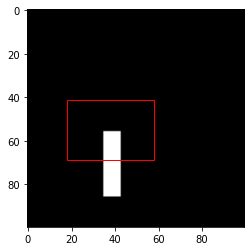

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


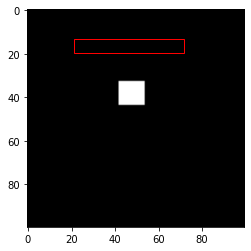

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


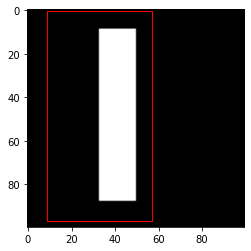

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


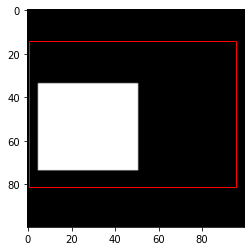

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


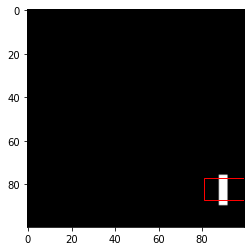

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


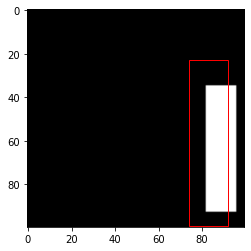

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


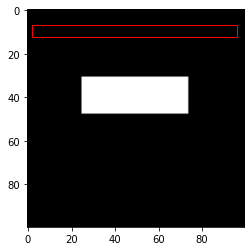

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


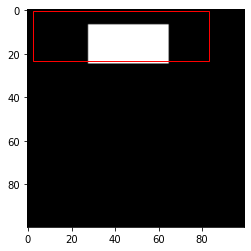

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


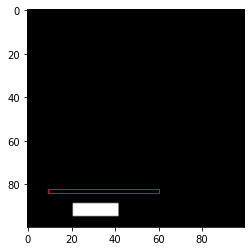

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


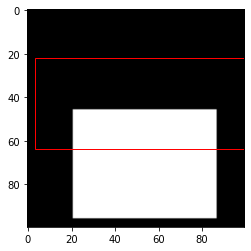

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


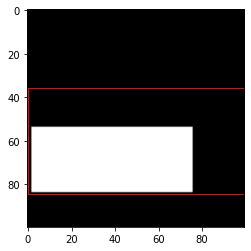

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


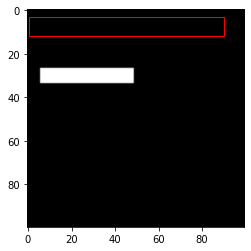

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


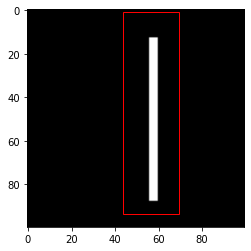

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


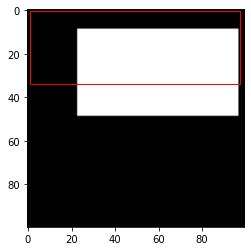

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


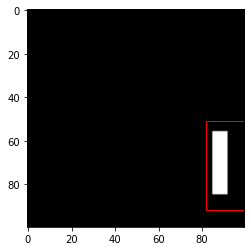

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


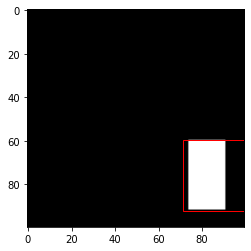

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


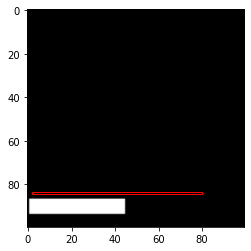

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


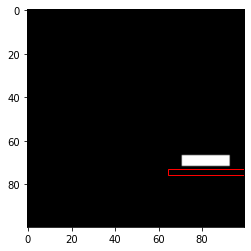

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


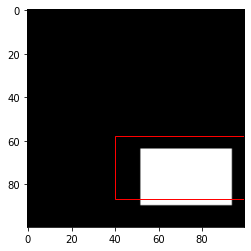

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


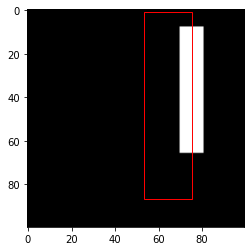

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


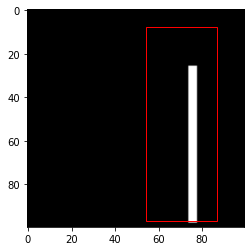

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


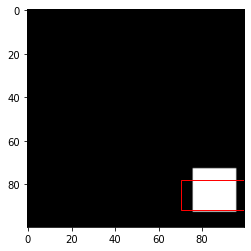

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


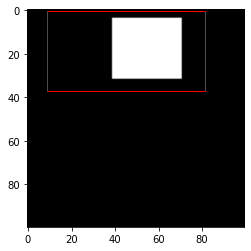

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


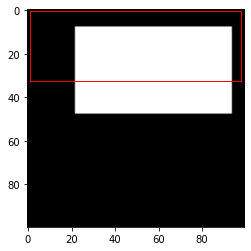

In [21]:
for _ in range(50):
    make_prediction(model)